#### Imports

In [1]:
import functools
import operator
import random
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(15)

#### Parameter definitions

In [4]:
DATA_DIR = Path('/home/jovyan/jigsaw-toxic/data')
JIGSAW_DIR = DATA_DIR / 'jigsaw-toxic-severity-rating'
DATASET_DIR = DATA_DIR / 'datasets/jigsaw-2021-kfold'

In [5]:
!mkdir -p $DATASET_DIR

#### Data loading

In [6]:
valid_df = pd.read_csv(JIGSAW_DIR / 'valid.csv')

In [7]:
valid_df

,less_toxic,more_toxic,certainty
0,"I think people say its not so absurd, because ...",Re Vandalism. . . . that is because the user ...,0.666667
1,You must have the lowest IQ of anyone on wikip...,Wha's a reliable source mike? Something that c...,1.000000
2,"Thanks for removing more of his anonymous, un...","To Bad\nyou dont have the balls to sign in, I ...",1.000000
3,"""\n\nActually, it clearly does not involve pow...",", 18 November 2006 (UTC)\n\nWell comrade. Look...",0.666667
4,You are not cool \n\nYou are the most hated f...,"""== Hey Fuck-head==\nHey, just wanted to say ""...",1.000000
...,...,...,...
10103,Heeeeeeeeeeeeeeyyyyyyyyyyyy dude! Sup!,you deleted my page \nand i am extrememly mad ...,1.000000
10104,ATTENTION:''''''\n\nANYONE WHO OPPOSES MY OPIN...,suck dick u disrespectful swearing wank!!,1.000000
10105,"Oh yah, and Bayerischermann is another guy try...",Thanks. Also thanks for freezing the article. ...,1.000000
10106,I had to chop out a section specifically compa...,"""\n\nHorrifyingly enough, """"ritualistic penis ...",0.666667


#### K-fold split

In [8]:
def split_to_k_folds(df: pd.DataFrame, k: int) -> pd.DataFrame:
    df = df.copy().sample(frac=1.0)
    df['fold'] = -1
    conn_group_list: t.List[t.Set[str]] = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        more_text, less_text = str(row['more_toxic']), str(row['less_toxic'])
        conn_group = {more_text, less_text}
        conn_group_to_join_list = [cg for cg in conn_group_list if more_text in cg or less_text in cg]
        conn_group_to_leave_list = [cg for cg in conn_group_list if more_text not in cg and less_text not in cg]
        conn_group_list = [functools.reduce(operator.ior, conn_group_to_join_list, conn_group)] + conn_group_to_leave_list
    print(f'Found {len(conn_group_list)} connectivity groups.')
    fold_set_list = [set() for _ in range(k)]
    for conn_group in conn_group_list:
        fold_set = min(fold_set_list, key=len)
        fold_set |= conn_group
    for i, text_set in enumerate(fold_set_list):
        df.loc[(df['more_toxic'].isin(text_set)) & (df['less_toxic'].isin(text_set)), 'fold'] = i
    return df


def test_k_fold_split(df: pd.DataFrame):
    text_set = set(df['more_toxic'].unique()) | set(df['less_toxic'].unique())
    for text in tqdm(text_set):
        assert len(df[(df['more_toxic'] == text) | (df['less_toxic'] == text)]['fold'].unique()) == 1


In [9]:
valid_5fold_df = split_to_k_folds(valid_df, k=5)

  0%|          | 0/10108 [00:00<?, ?it/s]

Found 4143 connectivity groups.


In [10]:
test_k_fold_split(valid_5fold_df)

  0%|          | 0/14251 [00:00<?, ?it/s]

In [11]:
valid_5fold_df

,less_toxic,more_toxic,certainty,fold
6538,Its clear to me that you haven't ever read a b...,and also don't give a shi'ite about your dis/...,0.666667,4
7331,I'd rather not revert you any further. Tell me...,Because TODD (shorthand from tosser) is part o...,1.000000,2
6562,"""::::::::::::::They aren't well then why do yo...","Hurricane Katrina \n\nYOU ARE CRAP, YOU FUCKI...",1.000000,1
8749,"""\nI'm not going to reply to your ignorants co...",Please see a picture of my balls. \n\nI am un...,0.666667,2
4587,"""\n\n Niqqudot \n\nYou interest in the alepbey...",what is a 3RR anyway....and\n\nOH DAMN...John ...,0.666667,2
...,...,...,...,...
6528,unblock|unblock my restriction from editing yo...,Gonna fuck you up \n\nYou little bitch. 86.17...,0.666667,4
2693,"""\n\nSigh\nAnother out-of-control administrato...",Islam\n\nI was reading the discussion between ...,1.000000,3
8076,Vinny Burgoo = suspected sock puppet\n\nAre yo...,the Jews should be expunged,1.000000,2
3829,"""\n\n Just a reference note.... \n\nJoke edit....","By the way, I didn't call you a pompous ass, I...",1.000000,1


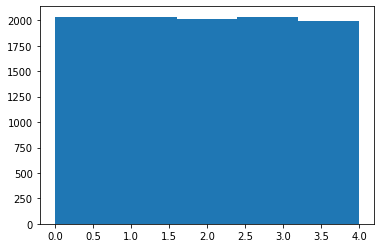

In [12]:
plt.hist(valid_5fold_df['fold'], bins=5);

In [13]:
valid_5fold_df.to_csv(DATASET_DIR / 'train_5fold.csv', index=False)

#### Data augmentation

In [14]:
valid_5fold_df = pd.read_csv(DATASET_DIR / 'train_5fold.csv')

In [15]:
def augment_by_connectivity_components_iteration(df: pd.DataFrame) -> pd.DataFrame:
    row_list = []
    pair_id_set = {str(row['less_toxic']) + ' ' + str(row['more_toxic']) for _, row in df.iterrows()}
    for _, row in tqdm(df.iterrows(), total=len(df)):
        more_toxic = str(row['more_toxic'])
        less_toxic = str(row['less_toxic'])
        fold = int(row['fold'])
        is_augmented = int(row.get('is_augmented', 0))
        certainty = float(row['certainty'])
        for _, less_row in df[df['more_toxic'] == less_toxic].iterrows():
            pair_id = str(less_row['less_toxic']) + ' ' + more_toxic
            if pair_id not in pair_id_set:
                pair_id_set.add(pair_id)
                row_list.append({
                    'less_toxic': less_row['less_toxic'],
                    'more_toxic': more_toxic,
                    'fold': fold,
                    'is_augmented': 1,
                    'certainty': float(less_row['certainty']) * certainty,
                })
        for _, more_row in df[df['less_toxic'] == more_toxic].iterrows():
            pair_id = less_toxic + ' ' + str(more_row['more_toxic'])
            if pair_id not in pair_id_set:
                pair_id_set.add(pair_id)
                row_list.append({
                    'less_toxic': less_toxic,
                    'more_toxic': more_row['more_toxic'],
                    'fold': fold,
                    'is_augmented': 1,
                    'certainty': float(more_row['certainty']) * certainty,
                })
        row_list.append({
            'less_toxic': less_toxic,
            'more_toxic': more_toxic,
            'fold': fold,
            'is_augmented': is_augmented,
            'certainty': certainty,
        })
    return pd.DataFrame(row_list)


def augment_by_connectivity_components(df: pd.DataFrame, min_new_samples: int) -> pd.DataFrame:
    i = 0
    while True:
        prev_len = len(df)
        df = augment_by_connectivity_components_iteration(df)
        new_samples = len(df) - prev_len
        print(f'i = {i}, new_samples = {new_samples}')
        if new_samples < min_new_samples:
            break
        i += 1
    return df

In [16]:
# valid_5fold_augmented_df = augment_by_connectivity_components(valid_5fold_df)
valid_5fold_augmented_df = augment_by_connectivity_components(valid_5fold_df, min_new_samples=10)

  0%|          | 0/10108 [00:00<?, ?it/s]

i = 0, new_samples = 2991


  0%|          | 0/13099 [00:00<?, ?it/s]

i = 1, new_samples = 1051


  0%|          | 0/14150 [00:00<?, ?it/s]

i = 2, new_samples = 91


  0%|          | 0/14241 [00:00<?, ?it/s]

i = 3, new_samples = 0


In [17]:
valid_5fold_augmented_df

,less_toxic,more_toxic,fold,is_augmented,certainty
0,Its clear to me that you haven't ever read a b...,and also don't give a shi'ite about your dis/...,4,0,0.666667
1,"Ding dong, the Witch is dead!\n\nSo, so happy ...",denny who the fuck r u \n\ndenny u little fuc...,2,1,0.666667
2,"Ding dong, the Witch is dead!\n\nSo, so happy ...",Because TODD (shorthand from tosser) is part o...,2,1,0.666667
3,"""\n\n Intro definition \n\n""""As with other rac...",denny who the fuck r u \n\ndenny u little fuc...,2,1,0.666667
4,"""\n\n Intro definition \n\n""""As with other rac...",Because TODD (shorthand from tosser) is part o...,2,1,0.666667
...,...,...,...,...,...
14236,unblock|unblock my restriction from editing yo...,Gonna fuck you up \n\nYou little bitch. 86.17...,4,0,0.666667
14237,"""\n\nSigh\nAnother out-of-control administrato...",Islam\n\nI was reading the discussion between ...,3,0,1.000000
14238,Vinny Burgoo = suspected sock puppet\n\nAre yo...,the Jews should be expunged,2,0,1.000000
14239,"""\n\n Just a reference note.... \n\nJoke edit....","By the way, I didn't call you a pompous ass, I...",1,0,1.000000


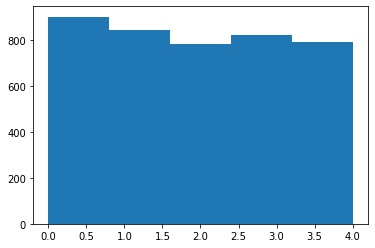

In [18]:
plt.hist(valid_5fold_augmented_df[valid_5fold_augmented_df['is_augmented'] == 1]['fold'], bins=5);

In [19]:
len({row['less_toxic'] + ' ' + row['more_toxic'] for _, row in tqdm(valid_5fold_augmented_df.iterrows(), total=len(valid_5fold_augmented_df))})

  0%|          | 0/14241 [00:00<?, ?it/s]

14241

In [20]:
valid_5fold_augmented_df.to_csv(DATASET_DIR / 'train_5fold_augmented_with_certainty_seed15.csv', index=False)